In [2]:
import numpy as np
import sdeint
import random
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import networkx as nx
import sys
sys.path.append("/home/simone/Scrivania/Tesi/wealth_condensation-main/python/")
import wealth_condensation as wc
from scipy.optimize import curve_fit
from scipy.special import gamma

In [2]:
def linear_function(w,alpha,b):
    return -alpha*w+b

In [3]:
def maggiorare(w,index):
    i=0
    while w[i]<index:
        i=i+1
        
    return i

In [4]:
def gen_decile_list(ranks,q,N):
    
    ranks_q=np.int32(q*ranks/N)
    j=0
    
    decile=[]

    for i in range(q):
    
        M=np.zeros(len(ranks_q[:,0]))
    
    
        while j<len(ranks_q[0,:]) and ranks_q[0,j]==i :
        
            M=M=np.vstack([M,ranks_q[:,j]])
        
            j=j+1
       
        M=M[1:,:]
        decile.append(M.tolist())
        
    return decile
        

In [5]:
def get_SQM (decile,nsteps):
    
    M=M=np.zeros(nsteps)
    
    for i in range(nsteps):
        diff=decile[i,:]-decile[0,:]
        diffsq=diff*diff
        mean=np.mean(diffsq)
        M[i]=mean ** 0.5
        
    return M

In [6]:
gamma(1.5)

0.8862269254527579

In [7]:
def cumulative_probability(p):
    p_c=np.cumsum(p)
    p_c=p_c[::-1]
    return p_c/np.sum(p)

In [8]:
def exponential_function(t, gamma, tau):

    return 0.9* np.exp(-np.power(t/tau, gamma)) + 0.1

In [15]:
def probability_fully_connected(wealth,alpha):

    wealth=np.sort(wealth)
  
    p=np.zeros(len(wealth))
    
    for i in range(len(wealth)):
        
        L=((alpha-1)**alpha)/gamma(alpha)
        
        a=np.exp((1-alpha)/(wealth[i]))
        
        den=(wealth[i])**(alpha+1)
        
        p[i]=L*(a/den)
        
    return p

In [6]:
N=1000
m=0.5
s=1
mu=0.1
sigma=1
phi=0.
f=0.
sigmat=0.
J0=0.5
t_tot=30
dt=.01
sim=20
n_cores=[500,450,400,350,300,250,200,150,100,50]
n_step=int(t_tot/dt)
df1=pd.DataFrame(columns=["sim","N_core","Wealth_Share","Wealth_Core","Wealth_Leaves"])
n_step_true=int(n_step/3)
alpha=1+(J0/(sigma**2))

In [6]:
for i in range(sim):
    for n_core in n_cores:
    
        n_branch=N-n_core
        G=wc.sun_graph_rand(n_core,n_branch)
        A0=nx.to_numpy_array(G)
        c=np.sum(A0,axis=0)
    
    
        A,B=wc.simulate.interaction_matrix_sun(N,mu,sigmat,m,phi,f,J0,A0,sigma,s,c)
    ## initial conditions
        x=np.ones(N+1)
        result=wc.simulate.integrate_sde(x,A,B,t_tot,dt)
        result=result[int(2*n_step/3):,:]
        result=result[:,:N]
   
        tot_wealth=result.sum(axis=1)
        wealth_share=result/tot_wealth.reshape(-1,1)
        core=wealth_share[:,:n_core]
        leaves=wealth_share[:,n_core:]
    
    
        df0 = pd.DataFrame({"sim":[sim],"N_core":[n_core],"Wealth_Share": [wealth_share],"Wealth_Core":[core],"Wealth_Leaves":[leaves]})
        df1=pd.concat([df1,df0])



In [7]:
df1.to_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/wealth.p.gz")

In [3]:
dw=pd.read_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/wealth.p.gz")

In [10]:
wealths=[]
for i in range(len(n_cores)):
    wealth=dw.iat[i,2]
    j=10
    while j < 200:
        wealth = np.append(wealth,dw.iat[j,2])
        j=j+10
    wealths.append(wealth)

In [9]:
wealths_core=[]
for i in range(len(n_cores)):
    wealth=dw.iat[i,3]
    j=10
    while j < 200:
        wealth = np.append(wealth,dw.iat[j,3])
        j=j+10
    wealths_core.append(wealth)

In [10]:
wealths_leaves=[]
for i in range(len(n_cores)):
    wealth=dw.iat[i,4]
    j=10
    while j < 200:
        wealth = np.append(wealth,dw.iat[j,4])
        j=j+10
    wealths_leaves.append(wealth)

In [25]:
dp=pd.DataFrame(columns=["n_cores","Wealth","Probability","Cumulative","Prob"])

In [26]:
for i in range(len(n_cores)):
    wealth_graph,p,P=wc.probability_distribution(wealths[i],80)
    p_c=cumulative_probability(p)
    dp0=pd.DataFrame({"n-cores":[n_cores[i]],"Wealth": [wealth_graph],"Probability":[p],"Cumulative":[p_c],"Prob":[P]})
    dp=pd.concat([dp,dp0])

In [27]:
dp.to_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/probability.p.gz") 

In [35]:
dp=pd.read_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/probability.p.gz")

In [11]:
wealth_tot=wealths[9]

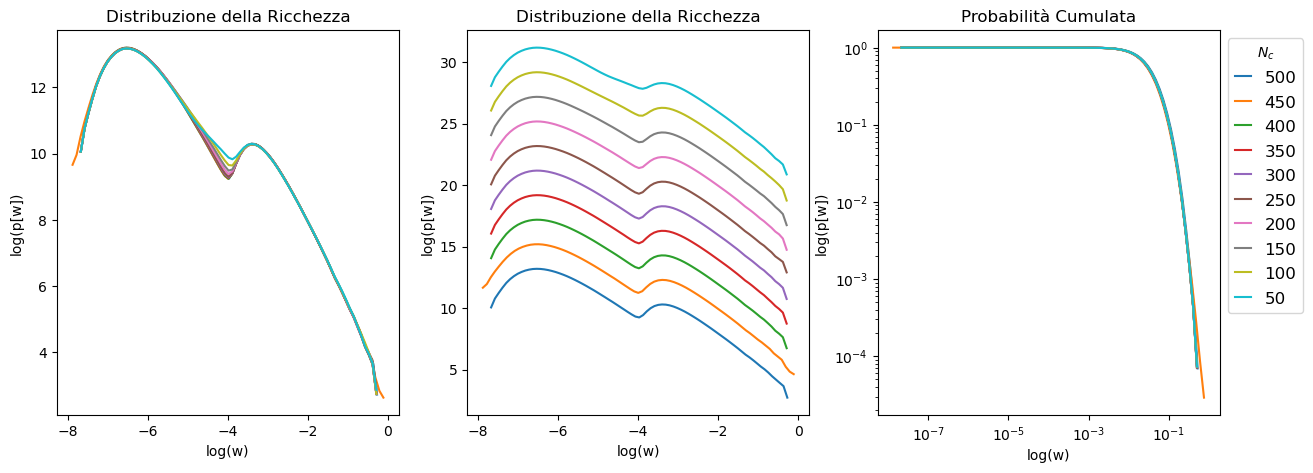

In [36]:
fig, axs=plt.subplots(1,3)

#full=probability_fully_connected(wealth_av_tot,alpha)

#axs[0].plot(np.log10(np.sort(wealth_av_tot)),np.log10(full)+12,linestyle='--', color='b')
#axs[0].set_ylim(1.5, 14) 
for i in range(len(n_cores)):
    
    w=np.log10(dp.iat[i,1])
    p=np.log10(dp.iat[i,2])
    p_c=dp.iat[i,3]
    P=np.log10(dp.iat[i,4])
  
    
    axs[0].plot(w,p,label=str(n_cores[i]))
    axs[0].set_xlabel("log(w)")
    axs[0].set_ylabel("log(p[w])")
    #axs[0,0].legend(title="$n_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=2,handleheight=1)
    axs[0].set_title('Distribuzione della Ricchezza')
    
   
    axs[1].plot(w,p+2*i,label=str(n_cores[i]))
    axs[1].set_xlabel("log(w)")
    axs[1].set_ylabel("log(p[w])")
    #axs[1].legend(title="$n_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=2,handleheight=1)
    axs[1].set_title('Distribuzione della Ricchezza')
    
    axs[2].plot(dp.iat[i,1],p_c,label=str(n_cores[i]))
    axs[2].set_xlabel("log(w)")
    axs[2].set_ylabel("log(p[w])")
    axs[2].set_yscale('log')
    axs[2].set_xscale('log')
    axs[2].legend(title="$N_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=1,handleheight=1)
    axs[2].set_title('Probabilità Cumulata')
    
fig.set_size_inches(15, 5)
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/probability.png",bbox_inches="tight")


In [14]:
bins_core=[50,45,40,35,30,25,20,20,20,20]
bins_leaves=[50,55,60,65,70,80,80,80,80,80]

In [11]:
dp_w=pd.DataFrame(columns=["n_cores","Wealth Core","Wealth Leaves","Probability Core","Probability Leaves"])

In [12]:
for i in range(len(n_cores)):
    wealth_graph_core,p_core,P_core=wc.probability_distribution(wealths_core[i],bins_core[i])
    p_leaves=wc.probability_distribution(wealths_leaves[i],bins_leaves[i])[1]
    w_leaves=wc.probability_distribution(wealths_leaves[i],bins_leaves[i])[0]
    dp0=pd.DataFrame({"n-cores":[n_cores[i]],"Wealth Core": [wealth_graph_core],"Wealth Leaves":[w_leaves],"Probability Core":[p_core],"Probability Leaves":[p_leaves]})
    dp_w=pd.concat([dp_w,dp0])

NameError: name 'wealths_core' is not defined

In [17]:
dp_w.to_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/probability_core.p.gz") 

In [13]:
dp_w=pd.read_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/probability_core.p.gz")

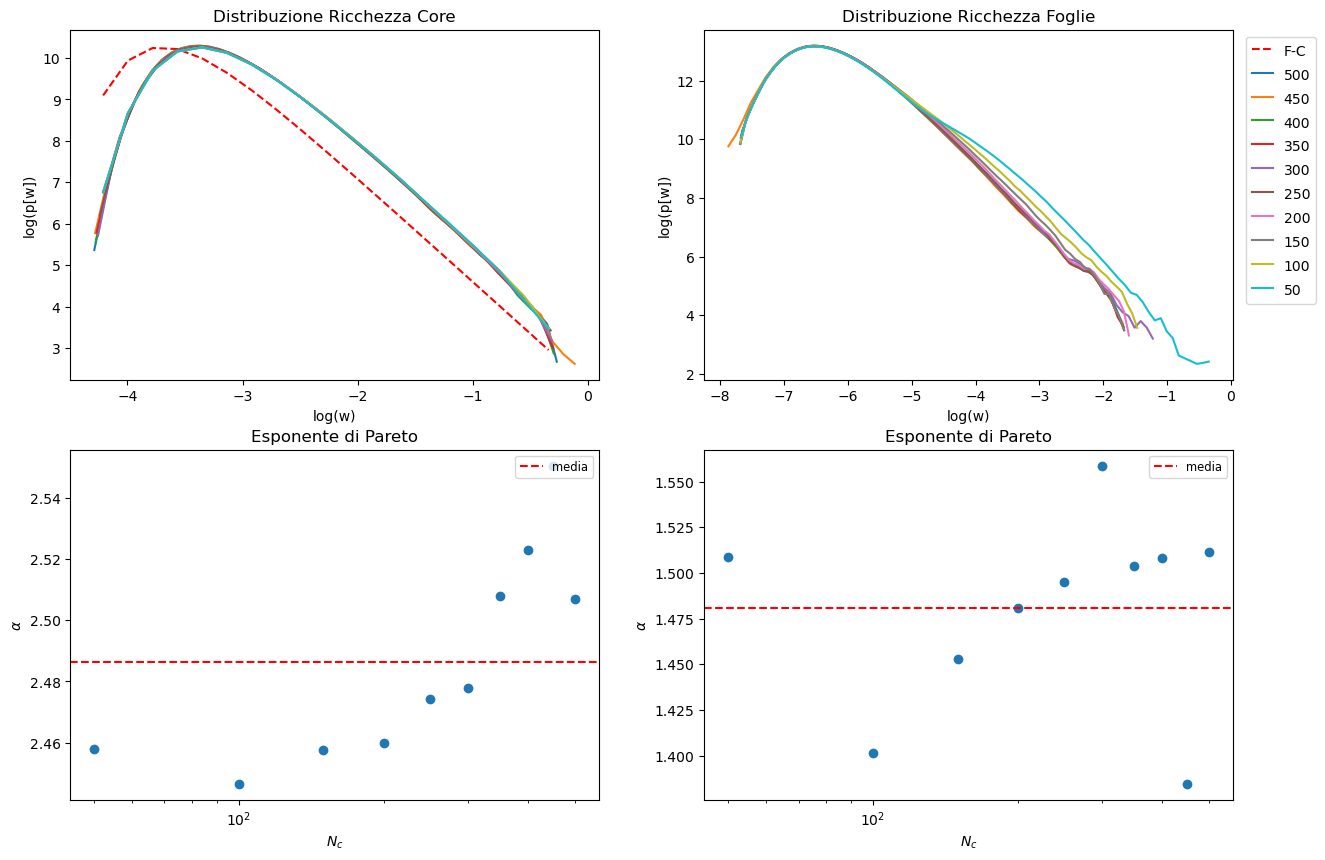

In [16]:
fig, axs=plt.subplots(2,2)
alpha_core=np.zeros(len(n_cores))
alpha_leaves=np.zeros(len(n_cores))
full=probability_fully_connected(1000*dp_w.iat[9,1],alpha)

axs[0,0].plot(np.log10(dp_w.iat[9,1]),np.log10(full)+10,linestyle='--', color='r',label='F-C')

for i in range(len(n_cores)):
    
    w_core=np.log10(dp_w.iat[i,1])
    p_core=np.log10(dp_w.iat[i,3])
    w_leaves=np.log10(dp_w.iat[i,2])
    p_leaves=np.log10(dp_w.iat[i,4])
    
    index_core=maggiorare(w_core,-3)
    x_core=w_core[index_core:]
    y_core=p_core[index_core:]
    
    index_leaves=maggiorare(w_leaves,-30)
    x_leaves=w_leaves[index_leaves:]
    y_leaves=p_leaves[index_leaves:]
    
    param_core, cov_core = curve_fit(linear_function,x_core,y_core)
    alpha_core[i]=param_core[0]
    param_leaves, cov_leaves = curve_fit(linear_function,x_leaves,y_leaves)
    alpha_leaves[i]=param_leaves[0]
    
    axs[0,0].plot(w_core,p_core,label=str(n_cores[i]))
    axs[0,0].set_xlabel("log(w)")
    axs[0,0].set_ylabel("log(p[w])")
    #axs[0,0].legend(title="$n_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=2,handleheight=1)
    axs[0,0].set_title('Distribuzione Ricchezza Core')
   
    axs[0,1].plot(w_leaves,p_leaves,label=str(n_cores[i]))
    axs[0,1].set_xlabel("log(w)")
    axs[0,1].set_ylabel("log(p[w])")
    #axs[0,1].legend(title="$N_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=1,handleheight=1.5)
    axs[0,1].set_title('Distribuzione Ricchezza Foglie')
    
    
axs[1,0].scatter(n_cores[::-1],alpha_core[::-1])
axs[1,0].axhline(y=np.mean(alpha_core), color='red', linestyle='--', label=f'media')
axs[1,0].set_xscale('log')
axs[1,0].set_title('Esponente di Pareto')
axs[1,0].set_xlabel("$N_c$")
axs[1,0].set_ylabel(r'$\alpha$')
axs[1,0].legend(loc='upper right', fontsize='small')


axs[1,1].scatter(n_cores[::-1],alpha_leaves[::-1])
axs[1,1].axhline(y=np.mean(alpha_leaves), color='red', linestyle='--', label=f'media')
axs[1,1].set_xscale('log')
axs[1,1].set_title('Esponente di Pareto')
axs[1,1].set_xlabel("$N_c$")
axs[1,1].set_ylabel(r'$\alpha$')
axs[1,1].legend(loc='upper right', fontsize='small')

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.96, 0.88),handlelength=1.5,handleheight=1.5)

fig.set_size_inches(15, 10)
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/probability_core.png",bbox_inches="tight")

In [16]:
d_q=[]

In [17]:
for i in range(len(n_cores)):
    par=np.argsort(dw.iat[i,2][0,:])
    w=dw.iat[i,2][:,par]
    
    rank=np.argsort(w, axis=1)
    df_r=pd.DataFrame(data=rank)
    rank_q=np.int32(10*df_r/N)
    
    df_q=pd.DataFrame(data=rank_q)
    
    d_q.append(df_q)
    

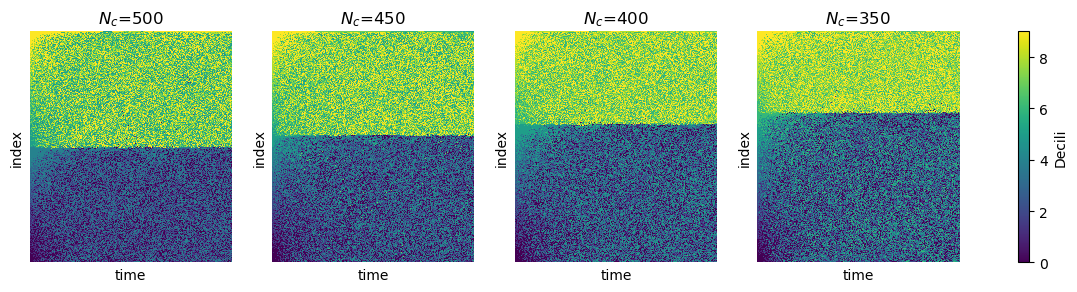

In [19]:
fig, axs = plt.subplots(1,4)
sns.heatmap(d_q[0].T[::-1],ax=axs[0], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[0].set_title('$N_c$=500')
axs[0].set_xlabel('time')
axs[0].set_ylabel('index')

sns.heatmap(d_q[1].T[::-1],ax=axs[1], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[1].set_title('$N_c$=450')
axs[1].set_xlabel('time')
axs[1].set_ylabel('index')

sns.heatmap(d_q[2].T[::-1],ax=axs[2], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[2].set_title('$N_c$=400')
axs[2].set_xlabel('time')
axs[2].set_ylabel('index')

sns.heatmap(d_q[3].T[::-1],ax=axs[3], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[3].set_title('$N_c$=350')
axs[3].set_xlabel('time')
axs[3].set_ylabel('index')

heatmaps = [axs[0].collections[0], axs[1].collections[0], axs[2].collections[0], axs[3].collections[0]]

cbar=fig.colorbar(heatmaps[0], ax=axs, location='right')
cbar.set_label('Decili')


fig.set_size_inches(15, 3)

plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/decileranks1.png",bbox_inches="tight")

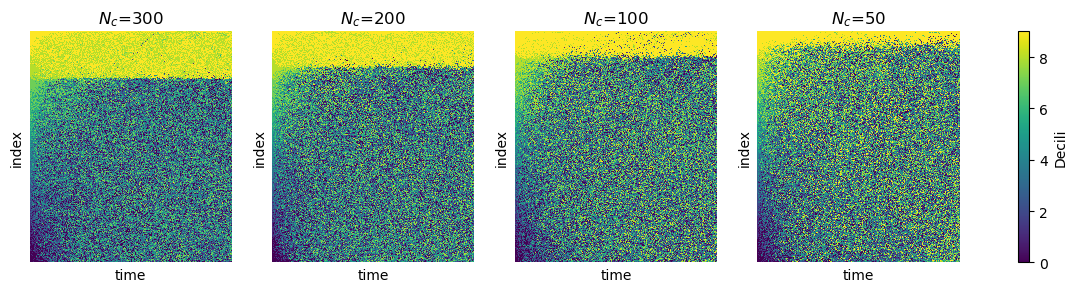

In [20]:
fig, axs = plt.subplots(1,4)
sns.heatmap(d_q[6].T[::-1],ax=axs[0], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[0].set_title('$N_c$=300')
axs[0].set_xlabel('time')
axs[0].set_ylabel('index')

sns.heatmap(d_q[7].T[::-1],ax=axs[1], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[1].set_title('$N_c$=200')
axs[1].set_xlabel('time')
axs[1].set_ylabel('index')

sns.heatmap(d_q[8].T[::-1],ax=axs[2], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[2].set_title('$N_c$=100')
axs[2].set_xlabel('time')
axs[2].set_ylabel('index')

sns.heatmap(d_q[9].T[::-1],ax=axs[3], cmap="viridis",cbar=False,xticklabels=False, yticklabels=False)

axs[3].set_title('$N_c$=50')
axs[3].set_xlabel('time')
axs[3].set_ylabel('index')

heatmaps = [axs[0].collections[0], axs[1].collections[0], axs[2].collections[0], axs[3].collections[0]]

cbar=fig.colorbar(heatmaps[0], ax=axs, location='right')
cbar.set_label('Decili')


fig.set_size_inches(15, 3)

plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/decileranks2.png",bbox_inches="tight")

In [7]:
dranks=pd.DataFrame(columns=["node_list","ranks","decile"])

In [8]:

for j in range(200):
    node_list=np.arange(N)
    k=np.argsort(dw.iat[j,2][0,:])
    w=dw.iat[j,2][:,k]
    node_list=node_list[k]
    
    ranks=np.argsort(w, axis=1)
    ranks_q=np.int32(10*ranks/N)
    
    
    dranks0 = pd.DataFrame({"node_list":[node_list],"ranks": [ranks],"decile":[ranks_q]})
    dranks = pd.concat([dranks,dranks0])

In [15]:
print(dranks.iat[199,0][999])

42


In [10]:
dpers=pd.DataFrame(columns=["top","mid","bot","shorrocks"])

In [11]:
for j in range(200):
    p_top=wc.analyze.persistence_top_series(dranks.iat[j,1],N,10,n_step_true)
    p_bot=wc.analyze.persistence_bottom_series(dranks.iat[j,1],N,10,n_step_true)
    p_mid=wc.analyze.persistence_5060_series(dranks.iat[j,1],N,10,n_step_true)
    sho=s_index=wc.analyze.shorrocks_series(dranks.iat[j,1],N,10,n_step_true)
    
    dpers0 = pd.DataFrame({"top":[p_top],"mid":[p_mid],"bot": [p_bot],"shorrocks":[sho]})
    dpers = pd.concat([dpers,dpers0])

In [12]:
dpers.to_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/persistence.p.gz")  

In [4]:
dpers=pd.read_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/persistence.p.gz")

In [5]:
tops=[]
mids=[]
bots=[]
shos=[]

In [6]:
for j in range(len(n_cores)):
    top=dpers.iat[j,0]
    mid=dpers.iat[j,1]
    bot=dpers.iat[j,2]
    sho=dpers.iat[j,3]
    i=10
    while i<200:
        top=top+dpers.iat[i+j,0]
        mid=mid+dpers.iat[i+j,1]
        bot=bot+dpers.iat[i+j,2]
        sho=sho+dpers.iat[i+j,3]
        i=i+10
        
    top=top/sim
    bot=bot/sim
    mid=mid/sim
    sho=sho/sim
   
    tops.append(top)
    bots.append(bot)
    mids.append(mid)
    shos.append(sho)

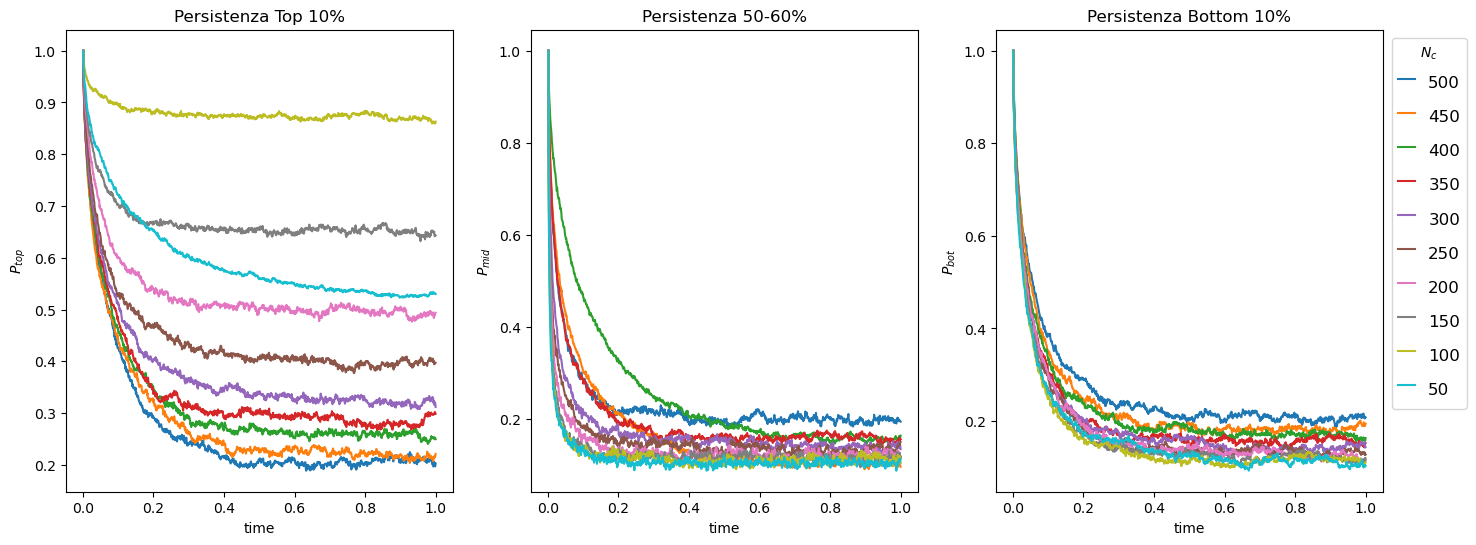

In [27]:
t=np.zeros(n_step_true)

for i in range (n_step_true):
    t[i]=(i+1)/1000
i=0
tau_top=np.zeros(len(n_cores))
gamma_top=np.zeros(len(n_cores))
tau_bot=np.zeros(len(n_cores))
gamma_bot=np.zeros(len(n_cores))
tau_mid=np.zeros(len(n_cores))
gamma_mid=np.zeros(len(n_cores))

fig, axs = plt.subplots(1,3) 

for i in range(10):
    
   
    
    
    axs[0].plot(t, tops[i])
    axs[0].set_title('Persistenza Top 10%')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('$P_{top}$')
        
    axs[1].plot(t, mids[i])
    axs[1].set_title('Persistenza 50-60%')
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('$P_{mid}$')
        
    axs[2].plot(t, bots[i],label=str(n_cores[i]))
    axs[2].set_title('Persistenza Bottom 10%')
    axs[2].set_xlabel('time')
    axs[2].set_ylabel('$P_{bot}$')
    axs[2].legend(title="$N_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=1,handleheight=2)
    
   
    
    
fig.set_size_inches(17,6) 
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/persistenza.png",bbox_inches="tight")

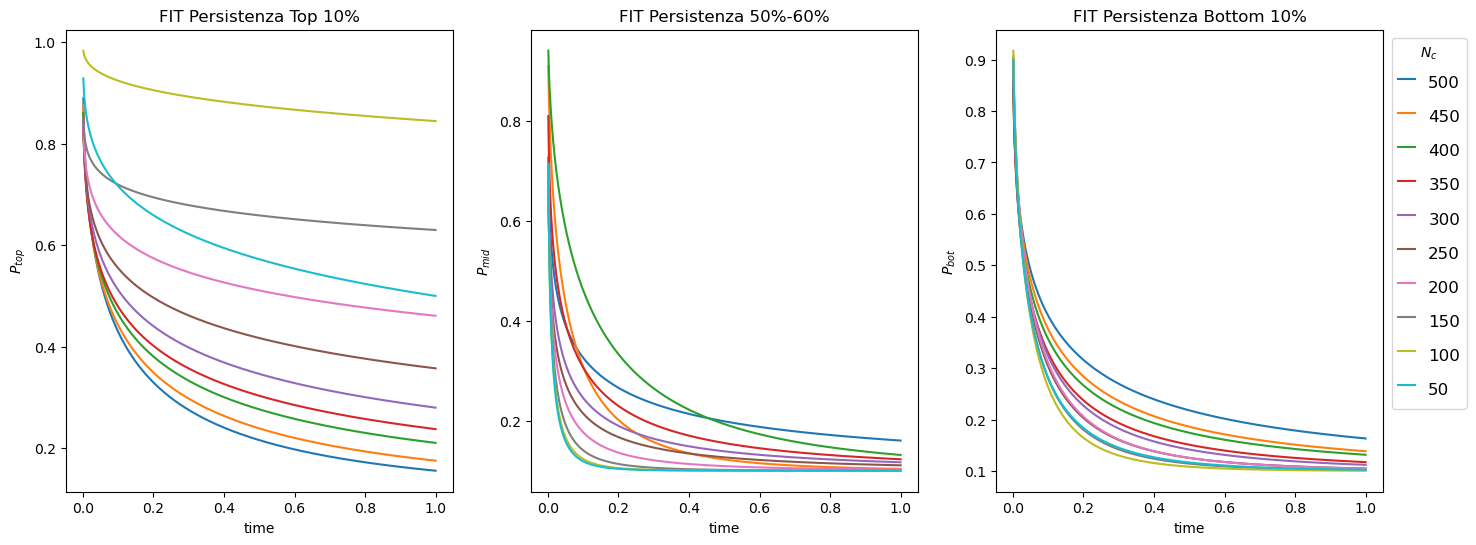

In [106]:
 fig, axs = plt.subplots(1,3)
    
for i in range(len(n_cores)):
               
    limiti_parametri = ([0.0, 0.0], [7.0, 150.0])
               
    popt_top, pcov_top = curve_fit(exponential_function, t, tops[i],bounds=limiti_parametri)
    popt_bot, pcov_bot = curve_fit(exponential_function, t, bots[i],bounds=limiti_parametri)
    popt_mid, pcov_mid = curve_fit(exponential_function, t, mids[i],bounds=limiti_parametri)
    
    
    tau_top[i]=popt_top[1]
    tau_bot[i]=popt_bot[1]
    tau_mid[i]=popt_mid[1]
    gamma_top[i]=popt_top[0]
    gamma_bot[i]=popt_bot[0]
    gamma_mid[i]=popt_mid[0]
    
    axs[0].plot(t,exponential_function(t, *popt_top ))
    axs[0].set_title('FIT Persistenza Top 10%')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('$P_{top}$')
    
    
   
    
    axs[1].plot(t,exponential_function(t, *popt_mid ))
    axs[1].set_title('FIT Persistenza 50%-60%')
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('$P_{mid}$')
    
    axs[2].plot(t,exponential_function(t, *popt_bot ),label=str(n_cores[i]))
    axs[2].set_title('FIT Persistenza Bottom 10%')
    axs[2].set_xlabel('time')
    axs[2].set_ylabel('$P_{bot}$')
    axs[2].legend(title="$N_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=1,handleheight=2)
    
fig.set_size_inches(17,6)

plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/FITpersistenza.png",bbox_inches="tight")

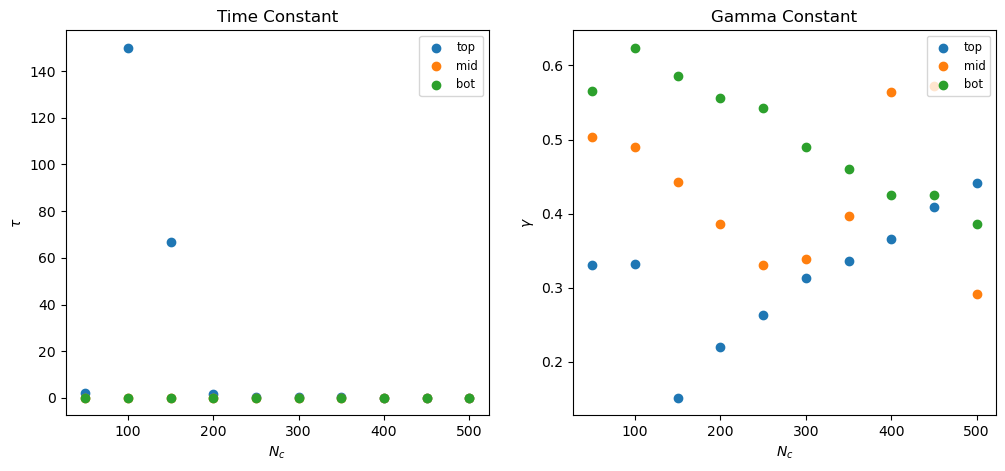

In [85]:
fig, axs=plt.subplots(1,2)


axs[0].scatter(n_cores, tau_top,label='top')
axs[0].scatter(n_cores, tau_mid,label='mid')
axs[0].scatter(n_cores, tau_bot,label='bot')

axs[0].set_title("Time Constant")
axs[0].set_xlabel('$N_c$')
axs[0].set_ylabel(r'$\tau$')
axs[0].legend(loc='upper right', fontsize='small')

axs[1].scatter(n_cores, gamma_top,label='top')
axs[1].scatter(n_cores, gamma_mid,label='mid')
axs[1].scatter(n_cores, gamma_bot,label='bot')

axs[1].set_title("Gamma Constant")
axs[1].set_xlabel('$N_c$')
axs[1].set_ylabel(r'$\gamma$')
axs[1].legend(loc='upper right', fontsize='small')

fig.set_size_inches(12, 5) 
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/tau.png",bbox_inches="tight")

In [6]:
indexes=[]

for j in range(9):
    index=np.zeros(200)
    for i in range(200):
        k=0
        
        while dranks.iat[i,2][0,k]<j+1:
            k=k+1
            
        index[i]=k
        
    indexes.append(index)

In [7]:
top_nodes=[]
for i in range(200):
    top=dranks.iat[i,0][int(indexes[8][i]):]
    
    top_nodes.append(top)

In [8]:
position_core=[]

for i in range(200):
    
    position=np.zeros(int(dw.iat[i,1]))
    k=0
    for j in range(N):
        if dranks.iat[i,0][j]<int(dw.iat[i,1]):
            position[k]=j
            k=k+1
    position_core.append(position)          

In [24]:
evolution_tops=[]
evolution_bots=[]
evolution_mids=[]

time=np.arange(0,1000,50)
labels=[r'$q_9$',r'$q_8$',r"$q_7$",r"$q_6$",r"$q_5$",r"$q_4$",r"$q_3$",r"$q_2$",r"$q_1$",r"$q_0$"]


for i in range(len(n_cores)):
    
    evolution_top=np.zeros((1000,10))
    evolution_bot=np.zeros((1000,10))
    evolution_mid=np.zeros((1000,10))
        
    decile_top=dranks.iat[i,2][:,int(indexes[8][i]):]
    decile_bot=dranks.iat[i,2][:,:int(indexes[0][i])]
    decile_mid=dranks.iat[i,2][:,int(indexes[4][i]):int(indexes[5][i])]
    
    
    for k in range(n_step_true):
        
        for j in range(10):
            
            norm_top=len(decile_top[0])
            pers_top=(decile_top[k]==j).sum()
            evolution_top[k,j]=pers_top/norm_top
                
            norm_bot=len(decile_bot[0])
            pers_bot=(decile_bot[k]==j).sum()
            evolution_bot[k,j]=pers_bot/norm_bot
                
            norm_mid=len(decile_mid[0])
            pers_mid=(decile_mid[k]==j).sum()
            evolution_mid[k,j]=pers_mid/norm_mid
                
                
    evolution_bot=evolution_bot[time]
    evolution_top=evolution_top[time]
    evolution_mid=evolution_mid[time]
            
    evolution_tops.append(evolution_top)
    evolution_bots.append(evolution_bot)
    evolution_mids.append(evolution_mid)
        

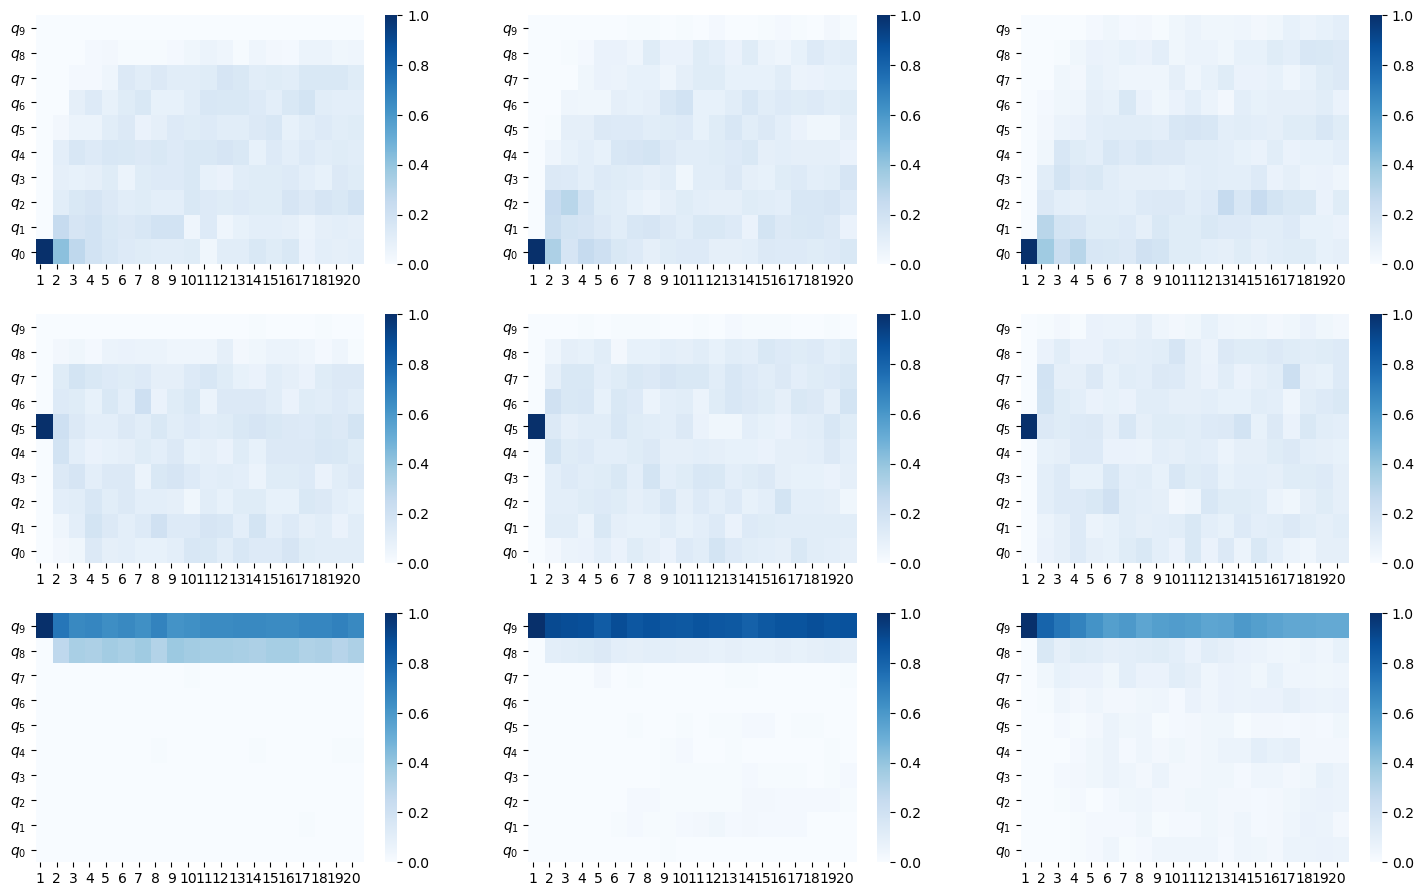

In [27]:
fig, axs = plt.subplots(3,3)

sns.heatmap(evolution_bots[8].T[::-1],ax=axs[0,1], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

axs[0,1].set_title('$N_c$=100')

sns.heatmap(evolution_tops[8].T[::-1],ax=axs[2,1], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

#axs[2,0].set_title('Persistence q9, n=100')

sns.heatmap(evolution_mids[8].T[::-1],ax=axs[1,1], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

#axs[1,0].set_title('Persistence q5, n=100')

sns.heatmap(evolution_bots[9].T[::-1],ax=axs[0,2], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

axs[0,2].set_title('$N_c$=50')

sns.heatmap(evolution_tops[9].T[::-1],ax=axs[2,2], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

#axs[2,2].set_title('Persistence q9, n=50')

sns.heatmap(evolution_mids[9].T[::-1],ax=axs[1,2], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

#axs[1,2].set_title('Persistence q5, n=50')

sns.heatmap(evolution_bots[7].T[::-1],ax=axs[0,0], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

axs[0,0].set_title('$N_c$=150')

sns.heatmap(evolution_tops[7].T[::-1],ax=axs[2,0], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)

#axs[2,2].set_title('Persistence q9, n=50')

sns.heatmap(evolution_mids[7].T[::-1],ax=axs[1,0], cmap="Blues",cbar=True,xticklabels=False, yticklabels=False)


for row in axs:
    for ax in row:
        ax.set_xticks(np.arange(0.25, 20.25, 1))
        ax.set_xticklabels(np.arange(1, 21))
        ax.set_yticks(np.arange(0.5, 10.5, 1))
        ax.set_yticklabels(labels)


fig.set_size_inches(18,11) 

plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/mobilità.png",bbox_inches="tight")

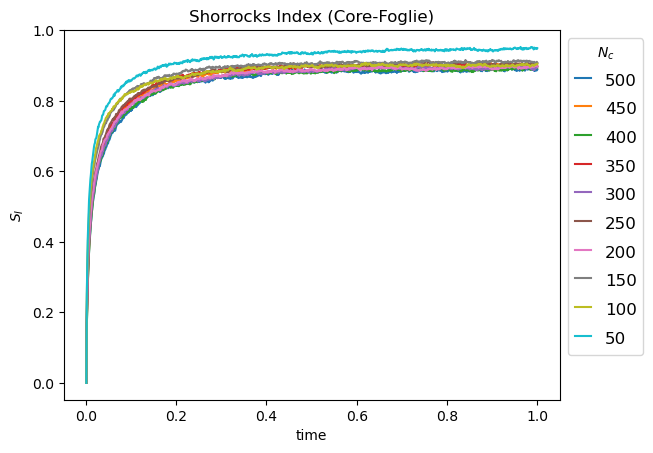

In [49]:
 for i in range(10):
    
    plt.plot(t,shos[i],label=str(n_cores[i]))
    
    plt.title('Shorrocks Index (Core-Foglie)')
    plt.xlabel('time')
    plt.ylabel('$S_I$')
    plt.legend(title="$N_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=1,handleheight=1.5)
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/shorrocks.png",bbox_inches="tight")

In [67]:
dshares=pd.DataFrame(columns=["top","bot","ratio"])

In [69]:
for i in range(200):
    Y=wc.analyze.inv_part_ratio(dw.iat[i,2],N)
    top_share=wc.analyze.top10_share(dw.iat[i,2],N)
    bot_share=wc.analyze.bottom10_share(dw.iat[i,2],N)
    
    dshares0 = pd.DataFrame({"top":[top_share],"bot": [bot_share],"ratio":[Y]})
    dshares = pd.concat([dshares,dshares0])
dshares.to_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/shares.p.gz")  

In [43]:
dshares=pd.read_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/shares.p.gz")

In [44]:
Y=[]
topshare=[]
botshare=[]

In [45]:
for j in range(10):
    ratio=dshares.iat[j,2]
    top_s=dshares.iat[j,0]
    bot_s=dshares.iat[j,1]
    
    i=10
    while i<200:
        top_s=top_s+dshares.iat[i+j,0]
        
        bot_s=bot_s+dshares.iat[i+j,1]
        
        ratio=ratio+dshares.iat[i+j,2]
        
        i=i+10
        
    top_s=top_s/sim
    bot_s=bot_s/sim
   
    ratio=ratio/sim
   
    topshare.append(top_s)
    botshare.append(bot_s)
    Y.append(ratio)

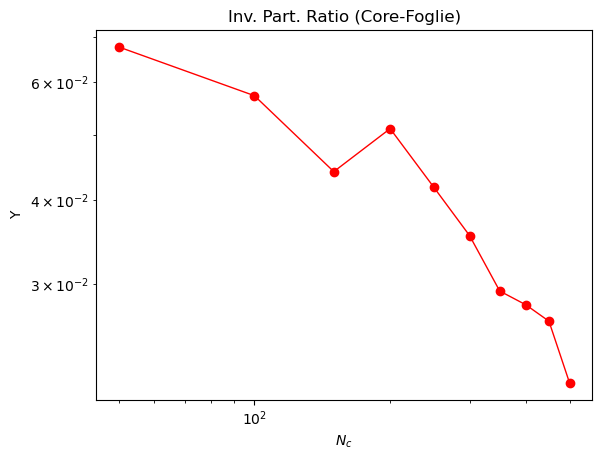

In [52]:
plt.scatter(n_cores,Y, color='red')
plt.plot(n_cores, Y, color='red', linestyle='-', linewidth=1)
plt.title('Inv. Part. Ratio (Core-Foglie)')
plt.xscale('log') 
plt.yscale('log') 
plt.xlabel("$N_c$")
plt.ylabel("Y")
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/ratio.png",bbox_inches="tight")

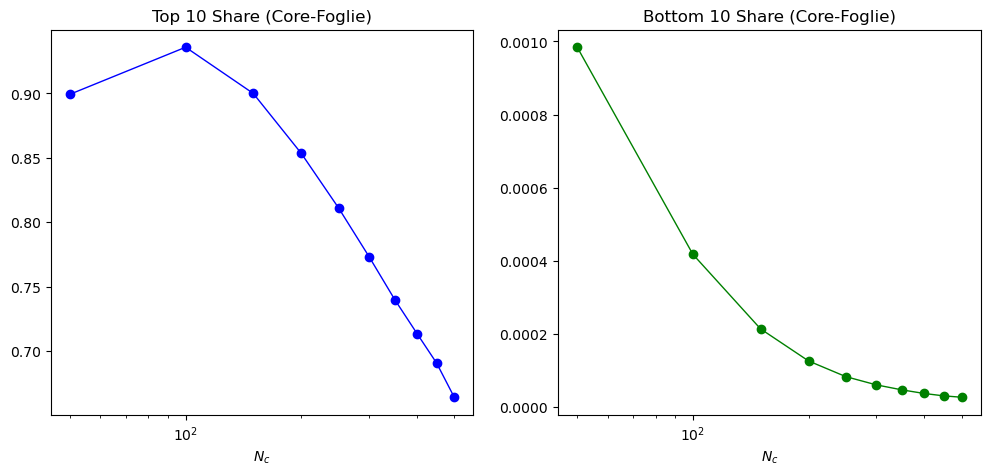

In [55]:
fig, axs=plt.subplots(1,2)


axs[0].scatter(n_cores,topshare, color='blue')
axs[0].plot(n_cores, topshare, color='blue', linestyle='-', linewidth=1)
axs[0].set_title("Top 10 Share (Core-Foglie)")
axs[0].set_xlabel("$N_c$")
axs[0].set_xscale('log') 

axs[1].scatter(n_cores,botshare, color='green')
axs[1].plot(n_cores, botshare, color='green', linestyle='-', linewidth=1) 
axs[1].set_title("Bottom 10 Share (Core-Foglie)")
axs[1].set_xlabel("$N_c$")
axs[1].set_xscale('log') 

fig.set_size_inches(12,5) 
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/shares.png",bbox_inches="tight")

In [86]:
dq=pd.DataFrame(columns=["quan","SQM"])


In [87]:
for i in range(200):
    decile=gen_decile_list(dranks.iat[i,1],10,N)
    for j in range(10):
        q=np.array(decile[j])
        q=q.T
        M=get_SQM(q,n_step_true)
        dq0=pd.DataFrame({"quan": [quan[j]],"SQM":[M]})
        dq=pd.concat([dq,dq0])

In [95]:
dM=pd.DataFrame(columns=["SQM"])

In [96]:
for j in range(100):
    M=dq.iat[j,1]
    i=100
    while i<2000:
        M=M+dq.iat[j+i,1]
        i=i+100
        
    M=M/sim
    
    dM0=pd.DataFrame({"SQM":[M]})
    dM=pd.concat([dM,dM0])
dM.to_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/SQM.p.gz") 

In [59]:
dM=pd.read_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/SQM.p.gz")
quan=np.arange(10)

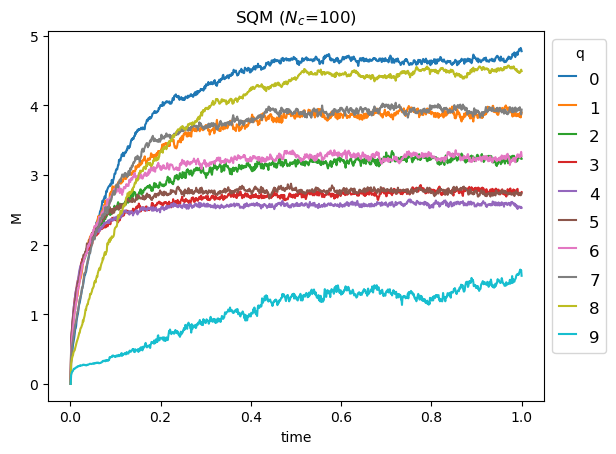

In [63]:
for i in range(10) :
    
    plt.plot(t,dM.iat[i+80,0],label=str(quan[i]))
    plt.title('SQM ($N_c$=100)')
    plt.xlabel('time')
    plt.ylabel('M')
    plt.legend(title="q",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=1,handleheight=1.5)
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/SQM.png",bbox_inches="tight")

In [9]:
decile_core=[]
decile_leaves=[]
for i in range(len(n_cores)):
    
    decile=dranks.iat[i,2]
    decile1=decile[:,position_core[i].astype(int)]
    decile2=np.delete(decile, position_core[i].astype(int), axis=1)
    
    decile_core.append(decile1)
    decile_leaves.append(decile2)

In [10]:
f_core=[]
q=np.arange(10)
for j in range(len(n_cores)):
    count=0
    for i in range(len(top_nodes[j])):
        if top_nodes[j][i]<n_cores[j]:
        
            count=count+1
    frac=count/len(top_nodes[j])
    
    f_core.append(frac)

for i in range(len(f_core)):
    print("La frazione di nodi core nel nono decile è" ,f_core[i],"con n=",n_cores[i])

    

La frazione di nodi core nel nono decile è 1.0 con n= 500
La frazione di nodi core nel nono decile è 1.0 con n= 450
La frazione di nodi core nel nono decile è 1.0 con n= 400
La frazione di nodi core nel nono decile è 1.0 con n= 350
La frazione di nodi core nel nono decile è 0.99 con n= 300
La frazione di nodi core nel nono decile è 0.99 con n= 250
La frazione di nodi core nel nono decile è 0.99 con n= 200
La frazione di nodi core nel nono decile è 0.99 con n= 150
La frazione di nodi core nel nono decile è 0.91 con n= 100
La frazione di nodi core nel nono decile è 0.5 con n= 50


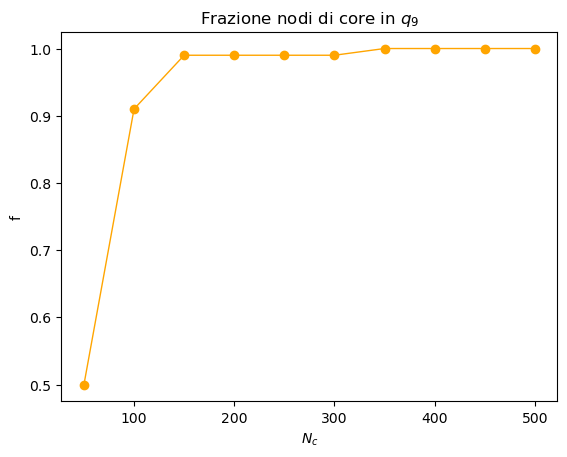

In [14]:
plt.scatter(n_cores,f_core,color='orange')
plt.plot(n_cores, f_core, color='orange', linestyle='-', linewidth=1)
plt.title('Frazione nodi di core in ''$q_9$')
plt.xlabel('$N_c$')
plt.ylabel('f')
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/frac.png",bbox_inches="tight")

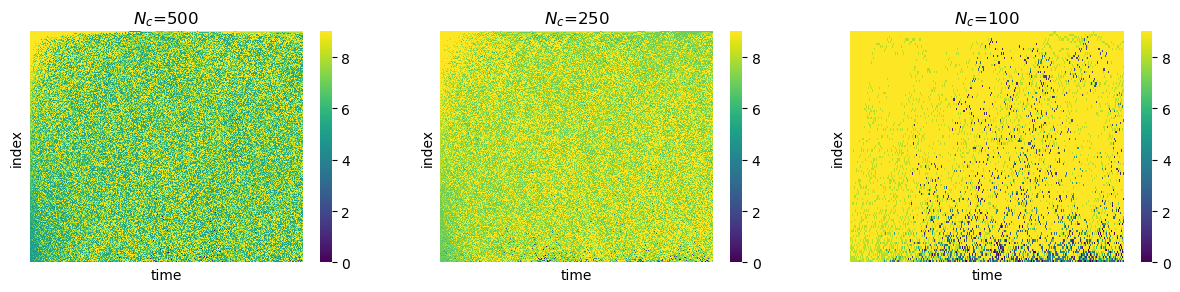

In [40]:
fig, axs = plt.subplots(1,3)

sns.heatmap(decile_core[0].T[::-1],ax=axs[0], cmap="viridis",cbar=True,xticklabels=False, yticklabels=False)

axs[0].set_title('$N_c$=500')
axs[0].set_xlabel('time')
axs[0].set_ylabel('index')

sns.heatmap(decile_core[4].T[::-1],ax=axs[1], cmap="viridis",cbar=True,xticklabels=False, yticklabels=False)

axs[1].set_title('$N_c$=250')
axs[1].set_xlabel('time')
axs[1].set_ylabel('index')

sns.heatmap(decile_core[8].T[::-1],ax=axs[2], cmap="viridis",cbar=True,xticklabels=False, yticklabels=False)

axs[2].set_title('$N_c$=100')
axs[2].set_xlabel('time')
axs[2].set_ylabel('index')



fig.set_size_inches(15,3) 
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/decileranks_core.png",bbox_inches="tight")

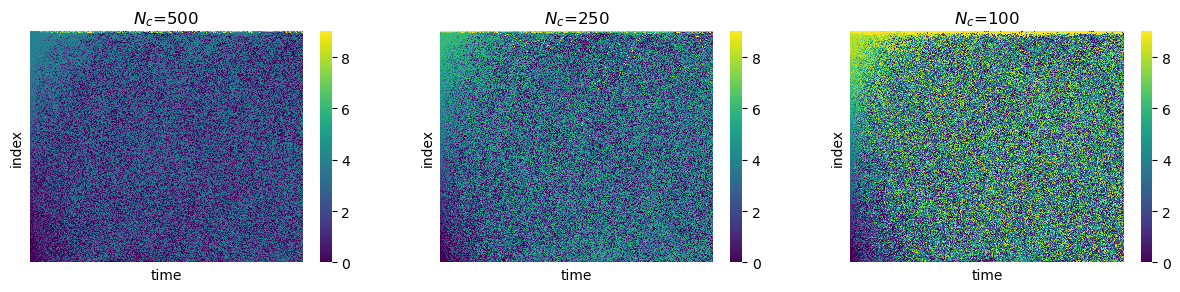

In [42]:
fig, axs = plt.subplots(1,3)

sns.heatmap(decile_leaves[0].T[::-1],ax=axs[0], cmap="viridis",cbar=True ,xticklabels=False, yticklabels=False)

axs[0].set_title('$N_c$=500')
axs[0].set_xlabel('time')
axs[0].set_ylabel('index')

sns.heatmap(decile_leaves[4].T[::-1],ax=axs[1], cmap="viridis",cbar=True,xticklabels=False, yticklabels=False)

axs[1].set_title('$N_c$=250')
axs[1].set_xlabel('time')
axs[1].set_ylabel('index')

sns.heatmap(decile_leaves[8].T[::-1],ax=axs[2], cmap="viridis",cbar=True,xticklabels=False, yticklabels=False)

axs[2].set_title('$N_c$=100')
axs[2].set_xlabel('time')
axs[2].set_ylabel('index')



fig.set_size_inches(15,3) 
plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/decileranks_leaves.png",bbox_inches="tight")

In [37]:
position_leaves=[]
list_node=np.arange(N)
for i in range(len(n_cores)):
    position_leaf=np.delete(list_node,position_core[i].astype(int))
    position_leaves.append(position_leaf)

In [19]:
dpers_core=pd.DataFrame(columns=["top"])

In [20]:
for i in range(200):
    p_top_core=wc.analyze.persistence_top_series_core(dranks.iat[i,1],N,position_core[i],10,n_step_true)
    dpers0 = pd.DataFrame({"top":[p_top_core]})
    dpers_core = pd.concat([dpers_core,dpers0])

In [21]:
dpers_core.to_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/persistence2.p.gz") 

In [65]:
dpers_core=pd.read_pickle("/home/simone/Scrivania/Tesi/data/Sun_rand/persistence2.p.gz")

In [67]:
pers_core=[]

In [68]:
for j in range(len(n_cores)):
    top=dpers_core.iat[j,0]
    
    i=10
    while i<200:
        top=top+dpers_core.iat[i+j,0]
       
        i=i+10
        
    top=top/sim
    
    pers_core.append(top)

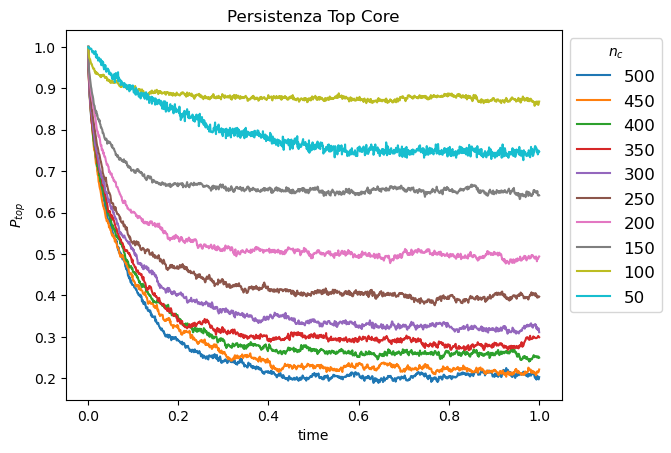

In [69]:


t=np.zeros(n_step_true)

for i in range (n_step_true):
    t[i]=(i+1)/1000

for j in range(len(n_cores)):
    
    
    plt.plot(t, pers_core[j],label=str(n_cores[j]))
    plt.title('Persistenza Top Core')
    plt.xlabel('time')
    plt.ylabel('$P_{top}$')
    plt.legend(title="$n_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=2,handleheight=1)
    


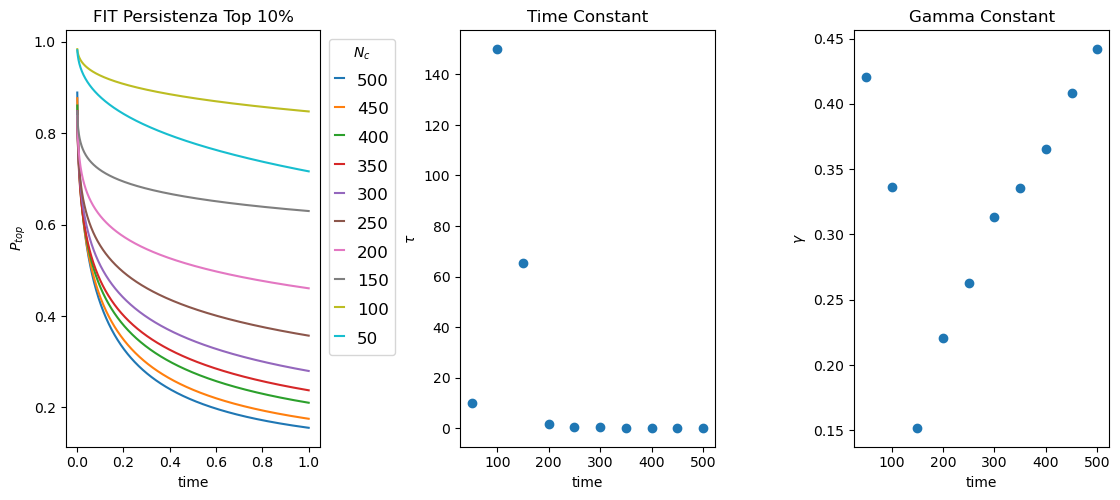

In [103]:
tau_core=np.zeros(len(n_cores))
gamma_core=np.zeros(len(n_cores))

fig, axs = plt.subplots(1,3)

for i in range(len(n_cores)):
               
    limiti_parametri = ([0.0, 0.0], [7.0, 150.0])
               
    popt_top_core, pcov_top_cpre = curve_fit(exponential_function, t, pers_core[i],bounds=limiti_parametri)

    
    
    tau_core[i]=popt_top_core[1]
    
    gamma_core[i]=popt_top_core[0]
    
    axs[0].plot(t,exponential_function(t, *popt_top_core ),label=str(n_cores[i]))
    axs[0].set_title('FIT Persistenza Top 10%')
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('$P_{top}$')
    
    
   
    
axs[1].scatter(n_cores,tau_core)
axs[1].set_title('Time Constant')
axs[1].set_xlabel('time')
axs[1].set_ylabel(r'$\tau$')
    
axs[2].scatter(n_cores,gamma_core)
axs[2].set_title('Gamma Constant')
axs[2].set_xlabel('time')
axs[2].set_ylabel(r'$\gamma$')
axs[0].legend(title="$N_c$",loc="upper left",bbox_to_anchor=(1, 1), fontsize="large",handlelength=0.5,handleheight=1.5)
fig.tight_layout(pad=-3)
fig.set_size_inches(10,4)

plt.savefig("/home/simone/Scrivania/Tesi/wealth_condensation-main/Figure/Sun/fitcore.png",bbox_inches="tight")